## BERT Fine-tuning

BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture. It was originally published by

Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: ["BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"](https://arxiv.org/abs/1810.04805), 2018.


Note: This notebook should be run using a GPU. In Colab, choose Runtime -> Change runtime type and select GPU.


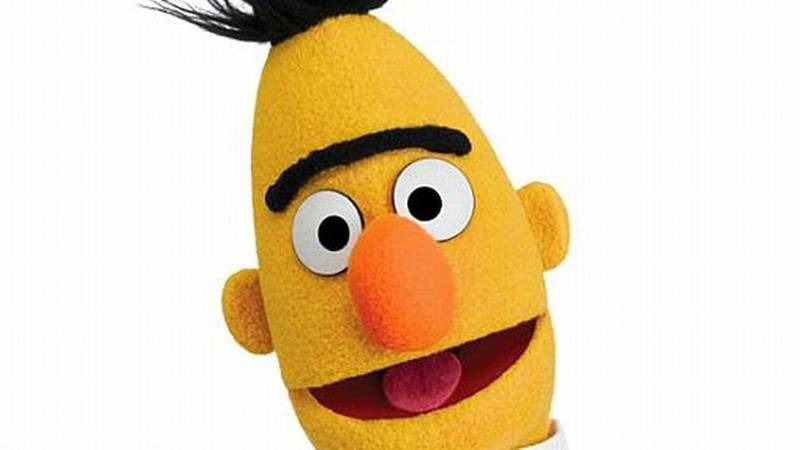


## Setup


In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q -U tf-models-official==2.7.0
!pip install -U tfds-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import io
from google.colab import files
import itertools
import random
tf.get_logger().setLevel('ERROR')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading BERT from TensorFlow Hub

There are different versions of Bert in Tensorflow Hub. This example is for bert_en_uncased_L-12_H-768_A-12, It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

For more BERT versions: https://tfhub.dev/google/collections/bert/1

In [3]:
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True)
bert_preprocess =  hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_version = 'bert_en_uncased_L-12_H-768_A-12 model'

## Define your model

You are now ready to define your model for sentence classification by feeding the preprocessed inputs through the BERT encoder and putting a linear classifier on top, and using dropout for regularization.

In [4]:
def define_model(num_classes,dropout_value=0.3,activation_function_for_output_layer='softmax'):
    text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name="input_layer")
    preprocessed_text=bert_preprocess(text_input)
    encoder_output=bert_encoder(preprocessed_text)
    l=tf.keras.layers.Dropout(dropout_value,name='dropout')(encoder_output['pooled_output'])
    l=tf.keras.layers.Dense(num_classes,activation=activation_function_for_output_layer,name='output')(l)
    model=tf.keras.Model(inputs=[text_input],outputs=[l])
    return model

## Build dataset

We will create a dataset from 3 text files.
Sentences from each text file will be tagged with a number:
*   0:for sentences from the first file.
*   1:for sentences from the second file.
*   2:for sentences from the third file.

We will then save the dataset in a csv file.

In [5]:
first_file = files.upload()
first_file_name = list(first_file.keys())[0]
print(f'Sentences from {first_file_name} will be tagged as 0')

Saving Harry Potter and the Prisoner of Azkaban.txt to Harry Potter and the Prisoner of Azkaban (4).txt
Sentences from Harry Potter and the Prisoner of Azkaban.txt will be tagged as 0


In [6]:
second_file = files.upload()
second_file_name = list(second_file.keys())[0]
print(f'Sentences from {second_file_name} will be tagged as 1')

Saving Harry Potter and the Philosophers Stone.txt to Harry Potter and the Philosophers Stone (4).txt
Sentences from Harry Potter and the Philosophers Stone.txt will be tagged as 1


In [7]:
third_file = files.upload()
third_file_name = list(third_file.keys())[0]
print(f'Sentences from {third_file_name} will be tagged as 2')

Saving Harry Potter and the Chamber of Secrets.txt to Harry Potter and the Chamber of Secrets (4).txt
Sentences from Harry Potter and the Chamber of Secrets.txt will be tagged as 2


preprocess data

In [8]:
def preprocess_file(file,file_name,label):
  data = pd.read_fwf(io.BytesIO(file[file_name]),sep=".",header=None) # Read text
  data=data[0]
  data = data.str.lower() #lowercase string from the given string
  # stop_words = set(stopwords.words("english"))
  # data = data.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))  # remove stopwords
  data.replace("[^a-z .]",'',regex=True, inplace = True) #remove all characters that are not letters,spaces and dots.
  data.replace(' +',' ',regex=True, inplace = True) # remove extra white space
  text = ""
  for line in data:
      text+=' '+ line
  sentences=text.split('.')
  sentences=[x for x in sentences if x]
  sentences=[x.strip() for x in sentences]
  sentences=[x for x in sentences if x!='' and x!=' ']
  new_data = []
  for sentence in sentences:
      if len(sentence.split())>1: # remove insignificant sentences
        new_data.append([sentence,label])
  return new_data

In [9]:
dataset_name = 'sentences'
first_data = preprocess_file(first_file,first_file_name,0)
second_data = preprocess_file(second_file,second_file_name,1)
third_data = preprocess_file(third_file,third_file_name,2)
allData = [x for x in itertools.chain(first_data, second_data, third_data)]
data_frame = pd.DataFrame(allData, columns=['sentence', 'label'])
data_frame.to_csv(dataset_name+'.csv')

In [10]:
num_classes = 3
num_examples = data_frame.shape[0]
sentence_features = ['sentence']
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}\n')
print('Samples from the dataset:')
data_frame.sample(n = 10)

This dataset has 19759 examples
Number of classes: 3

Samples from the dataset:


,sentence,label
466,her great red face started to expand her tiny ...,0
12081,she had started drawing up study schedules and...,1
8488,his page harry potter and the philosophers sto...,1
10712,wood told us,1
4274,seemed to think i cared more about winning the...,0
12512,we might have ter put it out of its misery,1
3482,doors and strings of enchanted candles hanging...,0
900,mum and dad dropped me off this morning with a...,0
19271,but after all it was merely a lucky chance tha...,2
11717,there was an inscription carved around the top...,1


In [11]:
sentences = data_frame['sentence'].values.tolist()
classes = data_frame['label'].values.tolist()
labels = []
for c in classes:
  label = [0] * 3
  label[c] = 1
  labels.append(label)

x,x_val,y,y_val=train_test_split(sentences,labels,test_size=0.2, shuffle=True)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, shuffle=True)
print(f'Example of a sentence and a label for it: {x_train[0]} : {y_train[0]}\n')

Example of a sentence and a label for it: yes ill have a spot more brandy vernon : [1, 0, 0]



The label is a vector of size 3, where the position of the value 1 in the vector represents from which text file the sentence is.
For example, if '1' is in position 2 int the vector it means that this sentence from the third file.

## Fine-tuned Bert. 
Finally, you can fine-tune the model end-to-end on the dataset.


Firstly, we will define the parameters:
*   epochs,batch_size,learning rate.
*   loss_function.
*   metrics.
*   steps_per_epoch, num_train_steps,num_warmup_steps,validation_steps.
*   optimizer: we will use AdamW. AdamW is a variant of the optimizer Adam that has an improved implementation of weight decay.
Using weight decay is a form of regularization to lower the chance of overfitting.

In [12]:
epochs = 3
batch_size = 32
init_lr = 2e-5

loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
train_data_size = len(x_train)
validation_data_size = len(x_val)
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10
validation_steps = validation_data_size // batch_size

input_optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')


Now you will define, compile and observe the model structure and its parameters.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['input_layer[0][0]']            
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

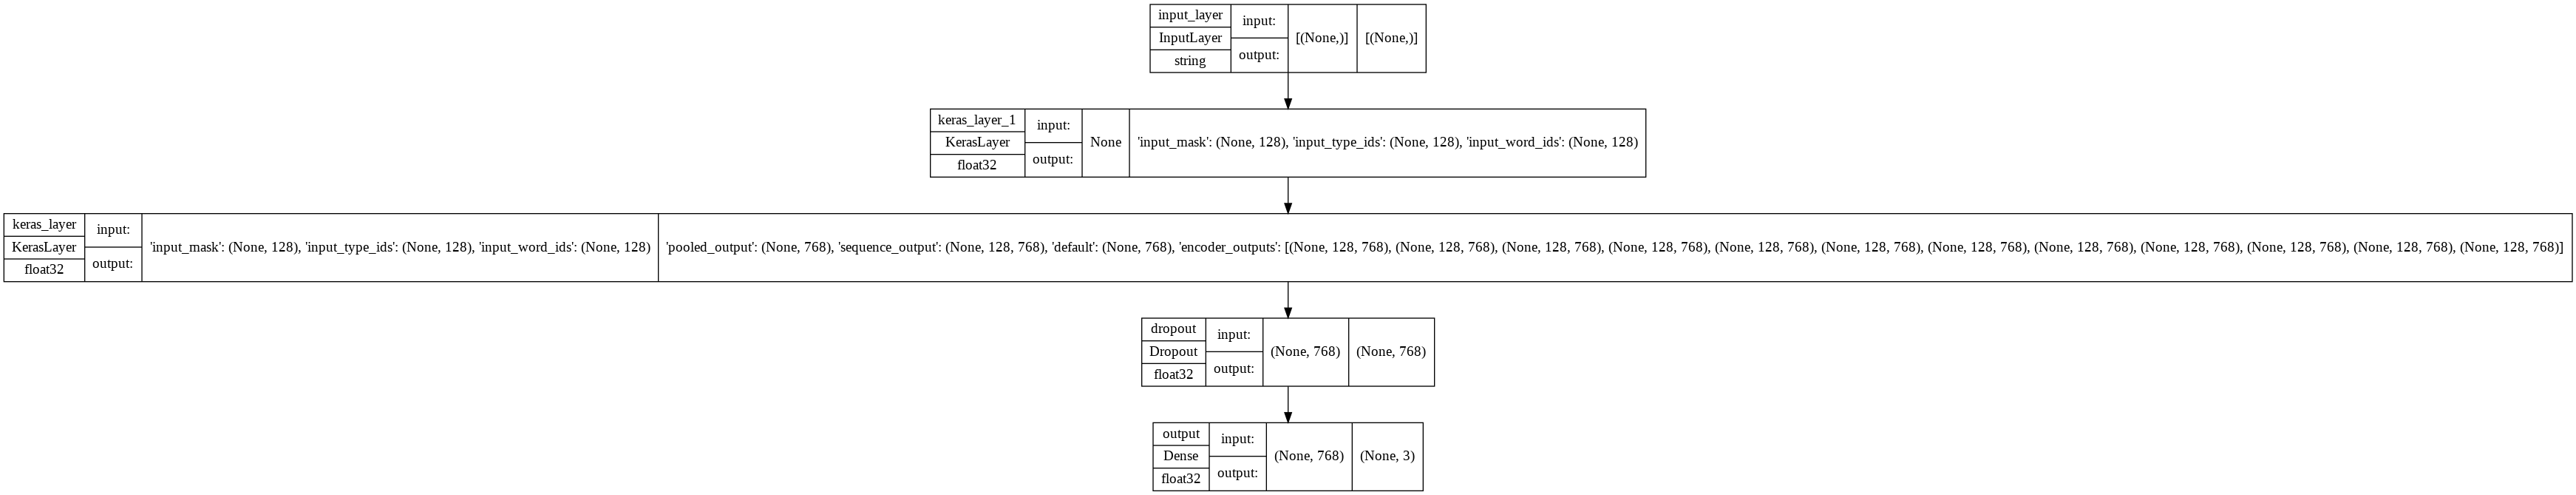

In [13]:
classifier_model = define_model(num_classes)
classifier_model.compile(optimizer = input_optimizer,loss=loss_function, metrics=['accuracy'])
classifier_model.summary() 
tf.keras.utils.plot_model(classifier_model, show_shapes=True, show_dtype=True)

Fine tuning Bert

In [14]:
print(f'Fine tuning {bert_version}')
classifier_model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val,y_val),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_steps=validation_steps)

Fine tuning bert_en_uncased_L-12_H-768_A-12 model
Epoch 1/3
395/395 [==============================] - 424s 1s/step - loss: 1.0726 - accuracy: 0.4347 - val_loss: 0.9002 - val_accuracy: 0.5238
Epoch 2/3
395/395 [==============================] - 356s 902ms/step - loss: 0.8400 - accuracy: 0.5871
Epoch 3/3
395/395 [==============================] - 356s 902ms/step - loss: 0.7141 - accuracy: 0.6735


## Export for inference

You will create a final model that has the preprocessing part and the fine-tuned BERT we've just created.

At inference time, preprocessing needs to be part of the model (because there is no longer a separate input queue as for training data that does it). Preprocessing is not just computation; it has its own resources (the vocab table) that must be attached to the Keras Model that is saved for export.
This final assembly is what will be saved.

In [15]:
main_save_path = './models'
saved_model_name = f'{dataset_name}_{bert_version}'
saved_model_path = os.path.join(main_save_path, saved_model_name)
print('Saving', saved_model_path)
# Save everything on the Colab host
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
classifier_model.save(saved_model_path, include_optimizer=False,options=save_options)

Saving ./models/sentences_bert_en_uncased_L-12_H-768_A-12 model


## Test the model

The final step is testing the results of your exported model.

Just to make some comparison, let's reload the model and test it using some inputs from the test split from the dataset.

In [16]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

In [17]:
def print_bert_results(test, bert_result,files_dict):
  bert_result_class = tf.argmax(bert_result, axis=1)[0]
  print('sentence:', test)
  result_class = tf.get_static_value(bert_result_class)
  print(f'This sentence is from {files_dict[result_class]}\n')



In [18]:
files_dict = {
    0:first_file_name,
    1:second_file_name,
    2:third_file_name
}
with tf.device('/job:localhost'):
  new_list = random.sample(x_test, 5)
  for test_row in new_list:
    result = reloaded_model([test_row])
    print_bert_results(test_row, result,files_dict)

sentence: pulling himself up harry stared out of the dark window and saw that they were now bowling along a completely different street
This sentence is from Harry Potter and the Chamber of Secrets.txt

sentence: i page harry potter and the philosophers stone j
This sentence is from Harry Potter and the Philosophers Stone.txt

sentence: harry had taken one step toward it when a slithering sound made him freeze where he stood
This sentence is from Harry Potter and the Philosophers Stone.txt

sentence: he slipped into a seat between ron and hermione at the gryffindor table and tried to ignore the fact that people were standing up to look at him
This sentence is from Harry Potter and the Philosophers Stone.txt

sentence: my dad too said harry astounded
This sentence is from Harry Potter and the Prisoner of Azkaban.txt

